In [1]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from torch import nn, optim
import torch.nn.functional as F
from arff2pandas import a2p

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 15, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
with open(r"C:/Users/DongJinhui/Desktop/ECG5000/ECG5000/ECG5000_TRAIN.arff") as f:
    train = a2p.load(f)
    
with open(r"C:/Users/DongJinhui/Desktop/ECG5000/ECG5000/ECG5000_TEST.arff") as f:
    test = a2p.load(f)
    

In [9]:
df = train.append(test)
df = df.sample(frac=1.0)
df.shape

(5000, 141)

In [10]:
df # 我们有5000个例子。每一行代表一个心跳记录

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,...,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,"target@{1,2,3,4,5}"
1001,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,-1.025095,...,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932,1
2086,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,...,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517,1
2153,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,-0.623098,...,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489,1
555,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,-1.025897,...,0.545222,0.649363,0.986846,1.234495,1.280039,1.215985,1.617971,2.196543,0.023843,1
205,-1.197203,-3.270123,-3.778723,-3.977574,-3.405060,-2.392634,-1.726322,-1.572748,-0.920075,-0.388731,...,0.828168,0.914338,1.063077,1.393479,1.469756,1.392281,1.144732,1.668263,1.734676,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3926,-0.248881,-1.346474,-1.855199,-2.519039,-2.947360,-3.233288,-3.087431,-2.668242,-1.970671,-1.390033,...,-1.157266,-1.605818,-2.286109,-3.247334,-3.551343,-3.426098,-2.171479,-1.380595,-0.378163,2
466,-0.287286,-1.199089,-1.563916,-2.078314,-2.456073,-2.508211,-2.465002,-2.445333,-2.320656,-1.995150,...,-2.061417,-2.679767,-3.228270,-3.584828,-3.629377,-3.000843,-2.079477,-1.307187,0.075742,2
2592,-1.032096,-2.811901,-3.588706,-3.883206,-3.279964,-2.275187,-1.771033,-1.603019,-0.956392,-0.764538,...,1.280471,1.353143,1.526594,1.429218,1.099634,1.245052,1.568047,1.776520,0.750669,1
3272,-1.592541,-2.461370,-2.524132,-3.062815,-2.968224,-2.784655,-2.738399,-2.431311,-2.063169,-1.555809,...,-2.179744,-2.624303,-3.107874,-3.102964,-2.746384,-1.972664,-1.077676,-0.707541,0.354016,2


In [12]:
CLASS_NORMAL = 1
'''
正常 (N)
室性早搏 (R-on-T PVC)
室性早搏 (PVC)
室上性早搏或异位搏动（SP 或 EB）
未分类的搏动 (UB)
'''
class_names = ['Normal','R on T','PVC','SP','UB']
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

df.target.value_counts()

1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64

[Text(0, 0, 'Normal'),
 Text(1, 0, 'R on T'),
 Text(2, 0, 'PVC'),
 Text(3, 0, 'SP'),
 Text(4, 0, 'UB')]

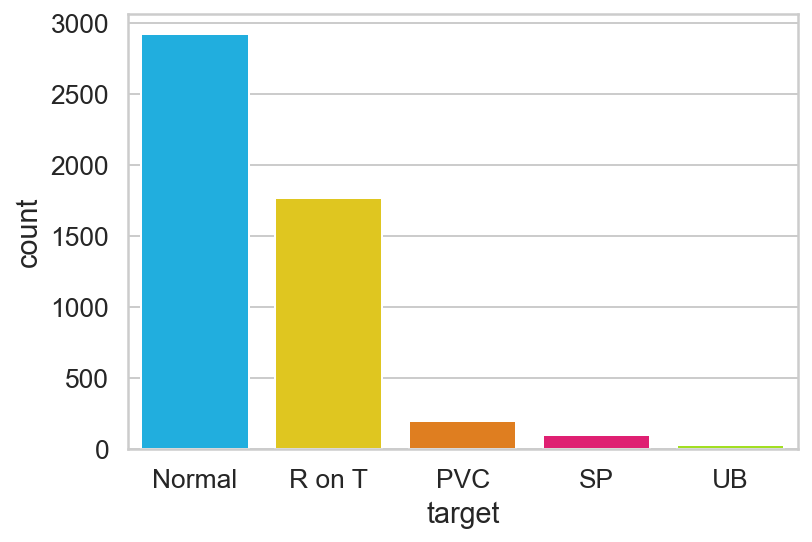

In [13]:
ax = sns.countplot(x='target', data=df, order=df['target'].value_counts().index)
ax.set_xticklabels(class_names)

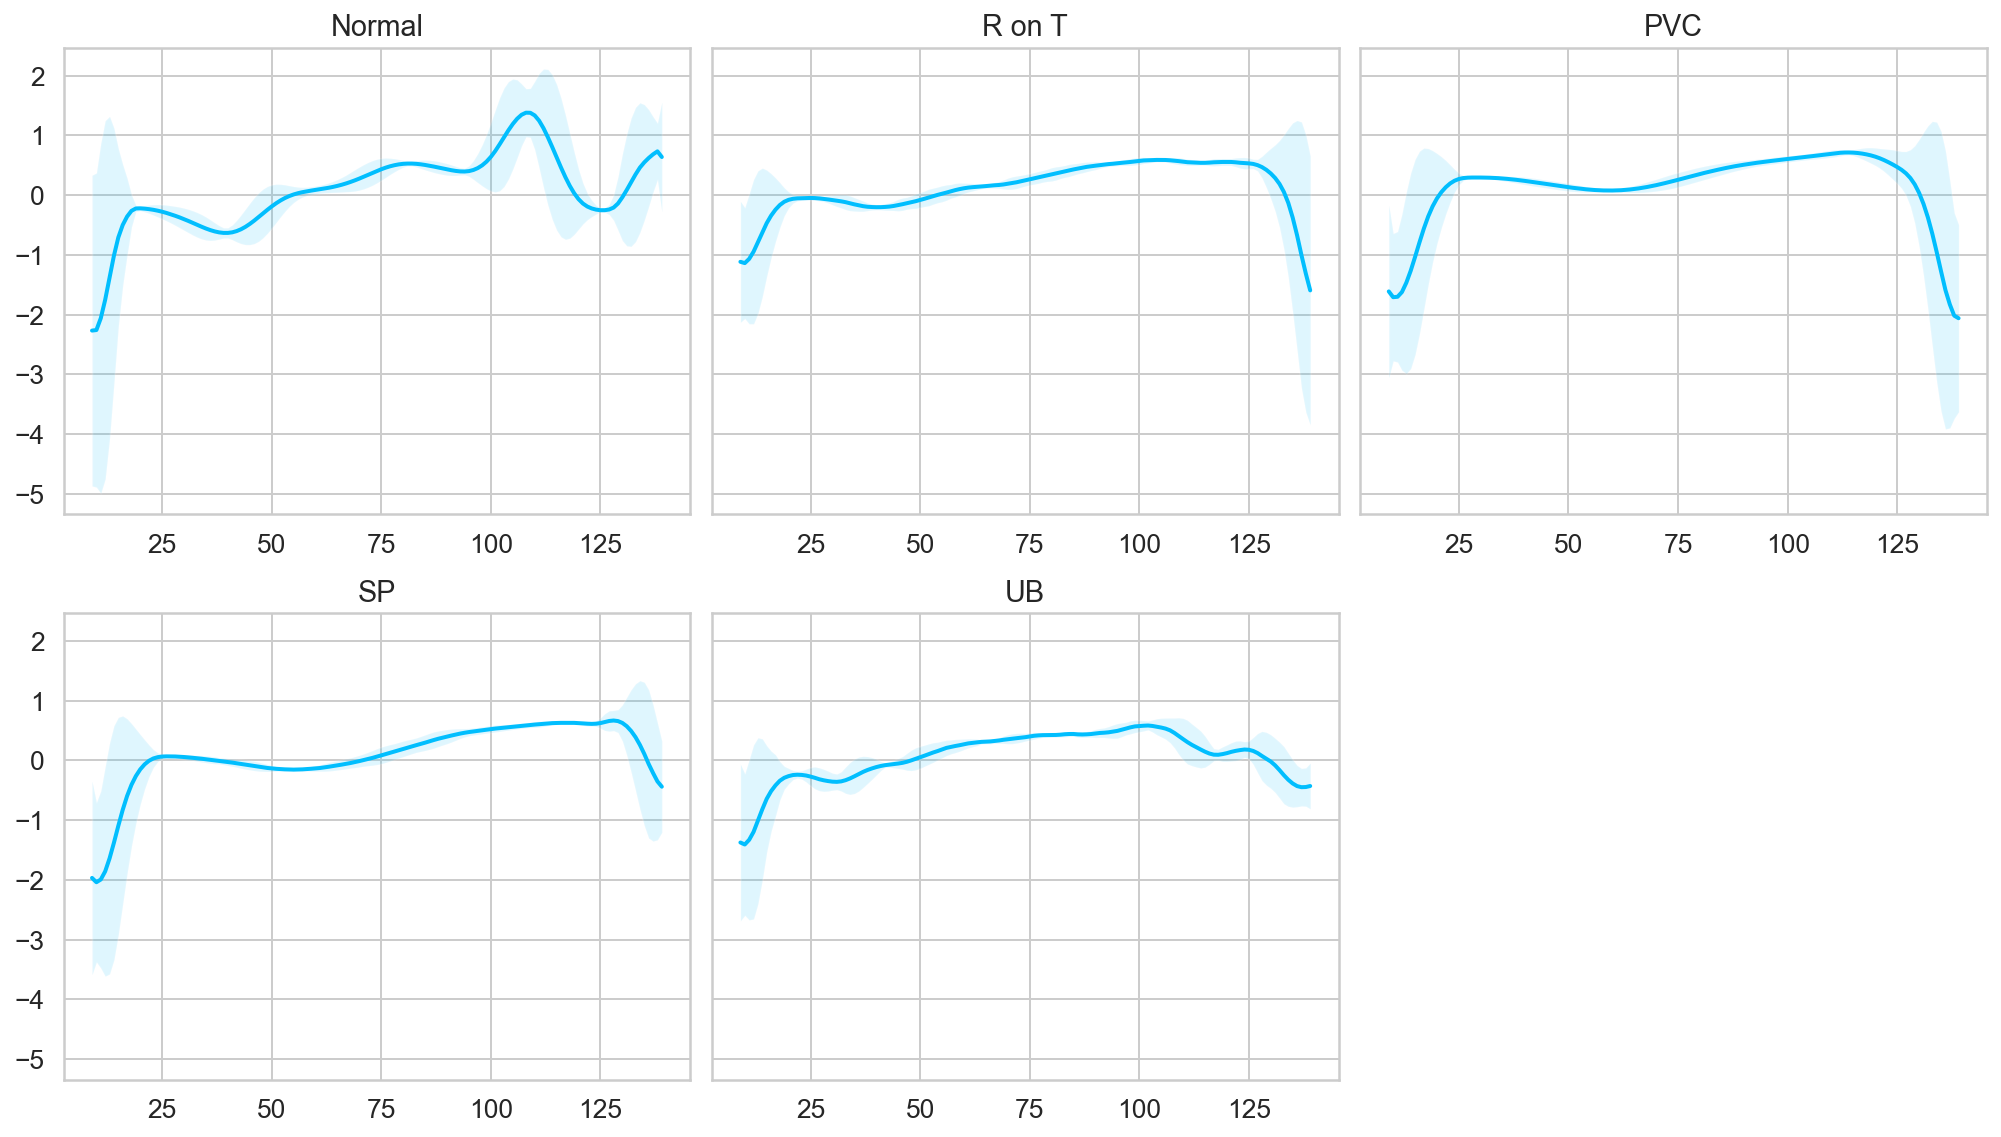

In [15]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
    time_series_df = pd.DataFrame(data)
    smooth_path = time_series_df.rolling(n_steps).mean()
    path_deviation = 2 * time_series_df.rolling(n_steps).std()
    under_line = (smooth_path - path_deviation)[0]
    over_line = (smooth_path + path_deviation)[0]
    
    ax.plot(smooth_path, linewidth=2)
    ax.fill_between(path_deviation.index, under_line, over_line, alpha=0.125)
    ax.set_title(class_name)
    
    
classes = df.target.unique()
fig,axs = plt.subplots(nrows=len(classes)//3+1, ncols=3, sharey=True, figsize=(14, 8))

for i, cls in enumerate(classes):
    ax = axs.flat[i]
    data = df[df.target==cls].drop(labels='target', axis=1).mean(axis=0).to_numpy()
    plot_time_series_class(data, class_names[i], ax)
    
fig.delaxes(axs.flat[-1])
fig.tight_layout()

In [16]:
normal_df = df[df.target == str(CLASS_NORMAL)].drop(labels='target', axis=1)
normal_df.shape

(2919, 140)

In [17]:
anormal_df = df[df.target != str(CLASS_NORMAL)].drop(labels='target', axis=1)
anormal_df.shape

(2081, 140)

In [20]:
train_df, val_df = train_test_split(normal_df, test_size=0.15, random_state=RANDOM_SEED)
val_df, test_df = train_test_split(val_df, test_size=0.33, random_state=RANDOM_SEED)

def create_dataset(df):
    sequences = df.astype(np.float32).to_numpy().tolist()
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
    n_seq, seq_len, n_feature = torch.stack(dataset).shape
    return dataset, seq_len, n_feature


train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anormal_df)

In [21]:
seq_len, n_features

(140, 1)

In [23]:
train_dataset[0].shape

torch.Size([140, 1])

In [24]:
type(train_dataset)

list

In [26]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()
        
        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2*embedding_dim
        
        self.rnn1 = nn.LSTM(input_size=n_features, hidden_size=self.hidden_dim, num_layers=1, batch_first=True)
        self.rnn2 = nn.LSTM(input_size=self.hidden_dim, hidden_size=self.embedding_dim, num_layers=1, batch_first=True)
    
    def forward(self, x):
        x = x.reshape(1, self.seq_len, self.n_features)
        x, (_,_) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)
        return hidden_n.reshape((self.n_features, self.embedding_dim))
    
    
class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()
        
        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2*input_dim, n_features
        
        self.rnn1 = nn.LSTM(input_size=input_dim, hidden_size=input_dim, num_layers=1, batch_first=True)
        self.rnn2 = nn.LSTM(input_size=input_dim, hidden_size=self.hidden_dim, num_layers=1, batch_first=True)
        
        self.output_layer = nn.Linear(self.hidden_dim, n_features)
        
    def forward(self, x):
        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))
        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.reshape((self.seq_len, self.hidden_dim))

        return self.output_layer(x)
    
    
class RecurrentAutoEncoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoEncoder, self).__init__()
        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [32]:
model = RecurrentAutoEncoder(seq_len, n_features, 32)
model = model.to(device)

In [33]:
def train_model(model, train_dataset, val_dataset, n_epochs):
    optimier = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.L1Loss(reduction='sum').to(device)
    history = dict(train=[], val=[])
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
    
    for epoch in range(1, n_epochs+1):
        print(f'{epoch}')
        model = model.train()
        train_losses = []
        for seq_true in train_dataset:
            optimier.zero_grad()
            
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)
            
            loss = criterion(seq_pred, seq_true)
            loss.backward()
            optimier.step()
            
            train_losses.append(loss.item())
            
        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for seq_true in val_dataset:
                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)
                
                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())
                
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        
        history['train'].append(train_loss)
        history['val'].append(val_loss)
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
        
    model.load_state_dict(best_model_wts)
    return model.eval(), history

In [34]:
model, history = train_model(model, train_dataset, val_dataset, n_epochs=150)

1
Epoch 1: train loss 62.789814708791205 val loss 51.736619448092206
2
Epoch 2: train loss 51.14237934790615 val loss 50.46695648037126
3
Epoch 3: train loss 50.50311531073045 val loss 51.43298395827362
4
Epoch 4: train loss 49.546449828849404 val loss 49.65836015252123
5
Epoch 5: train loss 46.77579560024226 val loss 48.73641993812327
6
Epoch 6: train loss 44.773538011353324 val loss 37.33056531912638
7
Epoch 7: train loss 31.112762097147673 val loss 34.13916279919725
8
Epoch 8: train loss 28.332139628685947 val loss 25.687731515018605
9
Epoch 9: train loss 26.899309053770818 val loss 27.871038423870203
10
Epoch 10: train loss 25.59791971934702 val loss 26.023377838395156
11


KeyboardInterrupt: 

In [ ]:
ax = plt.figure().gca()
ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show()

In [ ]:
# MODEL_PATH = 'model.pth'
# torch.save(model, MODEL_PATH)

# model = torch.load('model.pth')
# model = model.to(device)



In [ ]:
def predict(model, dataset):
    predictions, losses = [], []
    criterion = nn.L1Loss(reduction='sum').to(device)
    
    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)
            
            loss = criterion(seq_pred, seq_true)
            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
            
    return predictions, losses


In [ ]:
_, losses = predict(model, train_dataset)
sns.distplot(losses, bins=50, kde=True)

In [ ]:
THRESHOLD = 26

In [ ]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True)

In [ ]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

In [ ]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True)

In [ ]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

In [ ]:
def plot_prediction(data, model, title, ax):
    predictions, pred_losses = predict(model, [data])
    
    ax.plot(data, label='true')
    ax.plot(predictions[0], label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
    ax.legend()
# 绘图
fig, axs = plt.subplots(
              nrows=2,
              ncols=6,
              sharey=True,
              sharex=True,
              figsize=(22, 8)
            )

for i, data in enumerate(test_normal_dataset[:6]):
    plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
    plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout()

### 一维时序AutoEncoder - A Demo

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
import warnings
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
warnings.filterwarnings('ignore')
%matplotlib inline

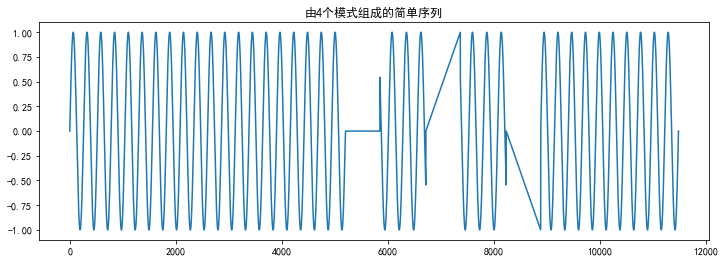

In [2]:
#use_cuda = torch.cuda.is_available()
use_cuda = False

FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

# 模拟时间序列生成

def Rand(num):
    res = []
    for j in range(num):
        res.append(random.random())
    return res

nb_periods=10
nb_points=2600
x = np.linspace(-nb_periods*np.pi, nb_periods*np.pi, nb_points)
x2 = np.linspace(int(-nb_periods*np.pi/3), int(nb_periods*np.pi/3), int(nb_points/3))
aa=list(np.sin(x))
bb=list(np.zeros(int(nb_points/4)))
cc=list(np.sin(x2))
dd=list(np.arange(int(nb_points/4))/int(nb_points/-4))
ee=list(np.arange(int(nb_points/4))/int(nb_points/4))
y=list(np.arange(len(aa+aa+bb+cc+dd+aa)))

serie_simple=np.array(aa+aa+bb+cc+ee+cc+dd+aa)

fig=plt.figure(figsize=(12,4))
plt.plot(serie_simple)
plt.title("由4个模式组成的简单序列")
plt.show()

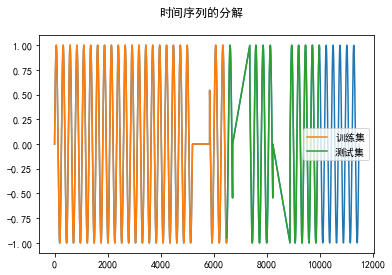

In [3]:
dataframe = pd.DataFrame(serie_simple.astype('float32'))
df_total=dataframe
plt.plot(df_total)

df= dataframe[:6500]
plt.plot(df,label="训练集")

df_test= dataframe[6500:10000]
plt.plot(df_test,label="测试集")
plt.legend()
plt.suptitle("时间序列的分解")
plt.show()

In [4]:
dataset = df.values
dataset_test = df_test.values

def normalize_test(dataset,dataset_test):
    max_value = np.max(dataset)
    min_value = np.min(dataset)
    scalar = max_value - min_value
    dataset = list(map(lambda x: (x-min_value)   / scalar, dataset))
    dataset_test = list(map(lambda x: (x-min_value)   / scalar, dataset_test))
    return dataset , dataset_test

dataset,dataset_test=normalize_test(dataset,dataset_test)

len(dataset),len(dataset_test)

(6500, 3500)

In [5]:
def rolling_window(data,look_back,pattern_indices=[]):
    """
    Inputs : 
        data = np array 1D 对应于一个时间序列
        pattern_indices = 当已知时，模式变化的指数
        look_back : 滑动窗口的大小
    Output : un np.array 带有“look_back”列的2D数组
    """
    dataX=[]
    for i in range(len(data)-look_back-1):
        a = data[i:(i+look_back)]
        if i == 0:
            print(type(a))
        dataX.append(list(a))

    dataX=np.array(dataX)
    return dataX

look_back=128

data_X=rolling_window(dataset,look_back)
print(data_X.shape)

data_X=data_X.reshape(-1, 1,look_back)
print(data_X.shape)


<class 'list'>
(6371, 128, 1)
(6371, 1, 128)


In [6]:
if use_cuda:
        #lgr.info ("Using the GPU")    
        train_x = torch.from_numpy(data_X).float().cuda() # Note the conversion for pytorch    
else:
        #lgr.info ("Using the CPU")
        train_x = torch.from_numpy(data_X).float() # Note the conversion for pytorch

dataset[-12:]

[array([0.0003812], dtype=float32),
 array([0.0009661], dtype=float32),
 array([0.00181779], dtype=float32),
 array([0.00293577], dtype=float32),
 array([0.00431949], dtype=float32),
 array([0.00596815], dtype=float32),
 array([0.00788096], dtype=float32),
 array([0.0100568], dtype=float32),
 array([0.01249457], dtype=float32),
 array([0.01519296], dtype=float32),
 array([0.01815048], dtype=float32),
 array([0.02136562], dtype=float32)]

In [7]:
data_X[-1,:,-10:]

array([[0.0003812 , 0.0009661 , 0.00181779, 0.00293577, 0.00431949,
        0.00596815, 0.00788096, 0.0100568 , 0.01249457, 0.01519296]],
      dtype=float32)

torch.Size([6371, 1, 128])

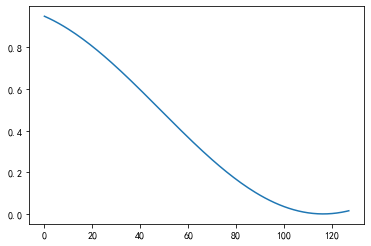

In [8]:
plt.plot(data_X[-1][0])
train_x.shape

In [9]:
class autoencoder(nn.Module):
    def __init__(self ,input_size):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(True),
            nn.Linear(128, 32),
            nn.ReLU(True),
            nn.Linear(32, 12),
            nn.ReLU(True), 
            nn.Linear(12, 3))
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 32),
            nn.ReLU(True),
            nn.Linear(32, 128),
            nn.ReLU(True),
            nn.Linear(128, input_size), 
            nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [10]:
net = autoencoder(look_back)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

# 训练我们的自动编码器将与我们习惯的有所不同。 假设您手头有一个包含许多非欺诈性交易的数据集。 
# 您要检测新事务上的任何异常。 =====我们将仅通过对正常交易训练模型来创建这种情况=====。
# X_train = X[X.Class == 正常]
# X_test = X[X.Class == 正常and异常]

Epoch: 50, Loss: 0.05612
Epoch: 100, Loss: 0.00209
Epoch: 150, Loss: 0.00111
Epoch: 200, Loss: 0.00085
Epoch: 250, Loss: 0.00063
Epoch: 300, Loss: 0.00049
Epoch: 350, Loss: 0.00040
Epoch: 400, Loss: 0.00032
Epoch: 450, Loss: 0.00031
Epoch: 500, Loss: 0.00077


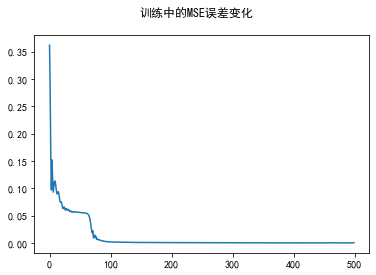

In [11]:
net_loss=[]
for e in range(500):
    var_x = Variable(train_x)
    out = net(var_x)
    loss = criterion(out, var_x)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    net_loss.append(loss.item())
    if (e + 1) % 50 == 0:
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))

plt.suptitle("训练中的MSE误差变化")
plt.plot(net_loss)
plt.show()

In [12]:
net = net.eval()

var_data = Variable(train_x)
pred_test = net(var_data)
pred_test = pred_test.view(-1,128)

def reconstruction_viz(train_x,autoencoder,lookback,index=0):
    var_data = Variable(train_x)
    pred_test = net(var_data)
    pred_test = pred_test.view(-1,lookback).data.cpu().numpy()
    data = train_x.view(-1,lookback).data.cpu().numpy()
    fig=plt.figure(figsize=(12,4))
    plt.plot(data[:,40],color="blue",label="真正的时间序列")
    plt.plot(pred_test[:,40],color="green",label="重建后的时间序列")
    plt.legend()
    plt.suptitle("一段真实时间序列曲线及其自动编码器的重建")
    plt.show()

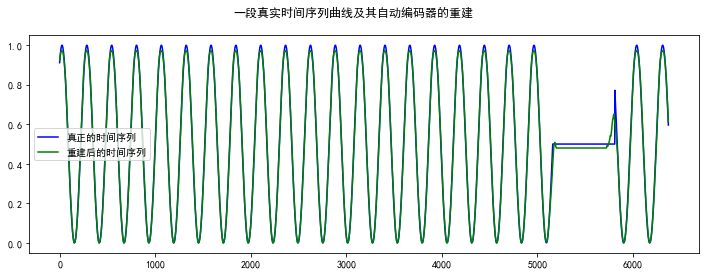

In [13]:
reconstruction_viz(train_x,net,look_back,index=0)

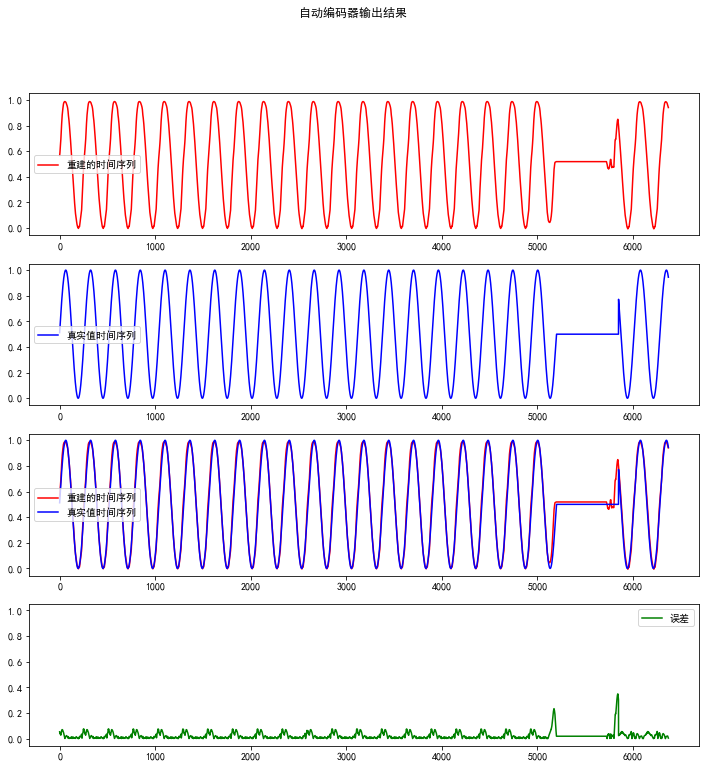

In [14]:
def reconstruction_viz2(train_x,autoencoder,lookback,index=0):
    var_data = Variable(train_x)
    pred_test = net(var_data)
    pred_test = pred_test.view(-1,lookback).data.cpu().numpy()
    data = train_x.view(-1,lookback).data.cpu().numpy()
    ecart= np.abs(np.subtract(data[:,1],pred_test[:,1]))
    
    
    fig, ax = plt.subplots(nrows=4, sharey=True,figsize=(12,12))
    ax[0].plot(pred_test[:,1], 'r', label='重建的时间序列')
    ax[0].legend(loc='best')
    ax[1].plot(data[:,1], 'b', label='真实值时间序列')
    ax[1].legend(loc='best')
    ax[2].plot(pred_test[:,1], 'r', label='重建的时间序列')
    ax[2].plot(data[:,1], 'b', label='真实值时间序列')
    ax[2].legend(loc='best')
    ax[3].plot(ecart, 'g', label='误差')
    ax[3].legend(loc='best')
    plt.legend()
    plt.suptitle("自动编码器输出结果")
    plt.show()

reconstruction_viz2(train_x,net,look_back,index=0)

<class 'list'>


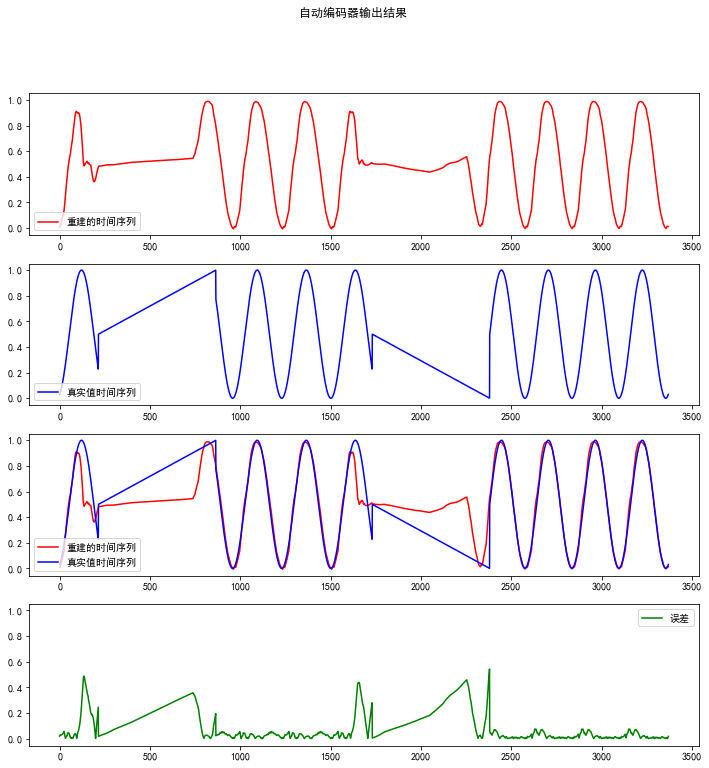

In [15]:
data_X_test=rolling_window(dataset_test,look_back)

data_X_test=data_X_test.reshape(-1, 1,look_back)

if use_cuda:
        #lgr.info ("Using the GPU")    
        test_x = torch.from_numpy(data_X_test).float().cuda() 
else:
        #lgr.info ("Using the CPU")
        test_x = torch.from_numpy(data_X_test).float() 

var_data_test = Variable(test_x)
pred_test = net(var_data_test)
pred_test = pred_test.view(-1,128)

reconstruction_viz2(test_x,net,look_back,index=0)